In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
    transforms.ToTensor()]) #

batch_size = 64
block = 3 

transform_test = transforms.Compose(
    [transforms.ToTensor()]) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

torch.manual_seed(43)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=8,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

val_dl = test_dl
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [3]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


images.shape: torch.Size([64, 3, 32, 32])


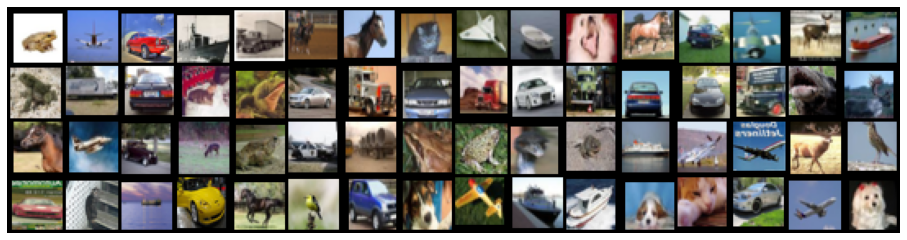

In [4]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

images.shape: torch.Size([64, 3, 32, 32])


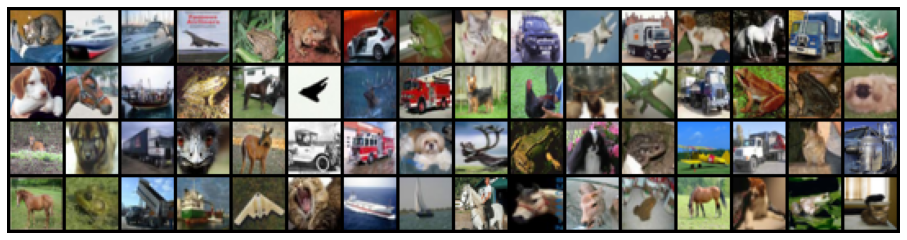

In [5]:
for images, _ in test_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [6]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()

        # Set first filter  
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        
        # He initialization: 
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter 
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')
        
        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')

        #nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define proportion or neurons to dropout
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)

        # Definebatch Normalization
        self.BN1 = nn.BatchNorm2d(32)
        self.BN2 = nn.BatchNorm2d(64)
        self.BN3 = nn.BatchNorm2d(128)
        self.BN4 = nn.BatchNorm1d(128)
        
        if block is 1:
          self.fc1 = nn.Linear(8192, 120)
          self.fc2 = nn.Linear(120, 10) # CHANGE 
          self.fc3 = nn.Linear(84, 10)
        else:  
          self.fc1 = nn.Linear(2048, 128)
          nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
          self.fc2 = nn.Linear(128, 10) # CHANGE 
          #self.fc3 = nn.Linear(400, 10)
        

    def forward(self, x):
        if block is 1:  
          # 1 VGG block: 
          x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
        else:
          # 3 VGG block 
          x = self.pool(F.relu(self.dropout1(self.conv1_2(F.relu(self.dropout1(self.conv1_1(x)))))))
          x = self.BN1(x)
          x = self.pool(F.relu(self.dropout2(self.conv2_2(F.relu(self.dropout2(self.conv2_1(x)))))))
          x = self.BN2(x)
          x = self.pool(F.relu(self.dropout3(self.conv3_2(F.relu(self.dropout3(self.conv3_1(x)))))))
          x = self.BN3(x)
          x = torch.flatten(x, 1) # flatten all dimensions except batch
          x = F.relu(self.dropout4(self.fc1(x)))
          x = self.BN4(x)
          x = self.fc2(x)


        #x = self.pool(F.relu(self.conv1_2(self.conv1_1(x))))
        #x = self.pool(F.relu(self.conv2_2(self.conv2_1(x))))

        #x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        return x


model = VGG() #to compile the model
model = model.to(device=device) #to send the model for training on either cuda or cpu
## Loss and optimizer
learning_rate = 0.005 #I picked this because it seems to be the most used by experts
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= learning_rate,momentum=0.9) #Adam seems to be the most popular for deep learning
#optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [7]:
loss_store_train =[]
loss_store_val = []
acc_store=[]
epoches=400
xaxis=np.arange(0,epoches)

for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    # model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch}: {loss_ep/len(train_dl):.3f}")
    loss_store_train.append(loss_ep/len(train_dl))

    # model.eval()
    valid_loss = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()

            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

Loss in epoch 0: 1.865
Got 4065 / 10000 with accuracy 40.65
Loss in epoch 1: 1.566
Got 4665 / 10000 with accuracy 46.65
Loss in epoch 2: 1.446
Got 5062 / 10000 with accuracy 50.62
Loss in epoch 3: 1.358
Got 5437 / 10000 with accuracy 54.37
Loss in epoch 4: 1.258
Got 5493 / 10000 with accuracy 54.93
Loss in epoch 5: 1.192
Got 5876 / 10000 with accuracy 58.76
Loss in epoch 6: 1.137
Got 6160 / 10000 with accuracy 61.60
Loss in epoch 7: 1.089
Got 6296 / 10000 with accuracy 62.96
Loss in epoch 8: 1.046
Got 6275 / 10000 with accuracy 62.75
Loss in epoch 9: 1.005
Got 6525 / 10000 with accuracy 65.25
Loss in epoch 10: 0.979
Got 6620 / 10000 with accuracy 66.20
Loss in epoch 11: 0.934
Got 6757 / 10000 with accuracy 67.57
Loss in epoch 12: 0.910
Got 6897 / 10000 with accuracy 68.97
Loss in epoch 13: 0.888
Got 6891 / 10000 with accuracy 68.91
Loss in epoch 14: 0.859
Got 7026 / 10000 with accuracy 70.26
Loss in epoch 15: 0.838
Got 7063 / 10000 with accuracy 70.63
Loss in epoch 16: 0.819
Got 7164 /

KeyboardInterrupt: 

Text(0, 0.5, 'Accuracy')

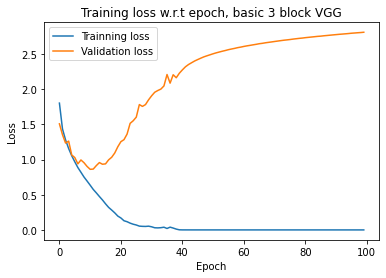

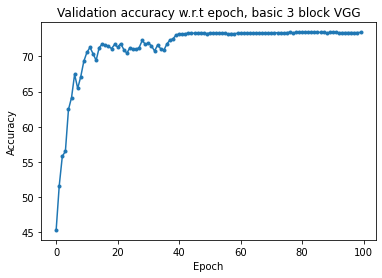

In [11]:

plt.figure(1)
plt.plot(loss_store_train,label = 'Trainning loss')
plt.plot(loss_val_new, label = 'Validation loss') 
plt.legend() 
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training loss w.r.t epoch, basic 3 block VGG') 
plt.figure(2)
plt.plot(acc_store,marker='.')
plt.title('Validation accuracy w.r.t epoch, basic 3 block VGG') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')

In [12]:
PATH = './cifar_net_baseline.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
dataiter = iter(test_dl)
images, labels = dataiter.next()

# print images
plt.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
net = VGG()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
        f"Accuracy of the network on the 10000 test images: {float(correct) / float(total) * 100:.2f}%"
)

NameError: name 'images' is not defined